### DEM ditch detection

In [1]:
#From functions 2.0

# General arr lib
import numpy as np

# Compile py code
from numba import jit, njit
from numba import prange

# Multithreading
import dask.array as da
import dask as dk
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
dk.config.set(scheduler='processes')

from dask_image.ndfilters import generic_filter as d_gf

from collections import deque

from skimage.filters import gabor
from skimage.restoration import  denoise_bilateral
from skimage.transform import resize  # For downsampling

from scipy.ndimage import gaussian_filter, generic_filter, binary_closing
from scipy.ndimage import median_filter, uniform_filter 
from scipy.ndimage import generic_filter

import datetime

import numpy as np
from numpy import random, nanmax, argmax, unravel_index
from scipy.spatial.distance import pdist, squareform
import scipy.stats.mstats as ms
from scipy.stats import skew
import scipy.ndimage.morphology as morph
from scipy import ndimage
from PIL import Image
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
import os
import pandas as pd
import random
import math
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.filters import gabor
from skimage.util import random_noise
from collections import deque
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, confusion_matrix, precision_score
from numba import jit
from numba import prange


from Functions import general_functions
from Functions.general_functions import create_circular_mask

Detected ditches: 2879023 pixels


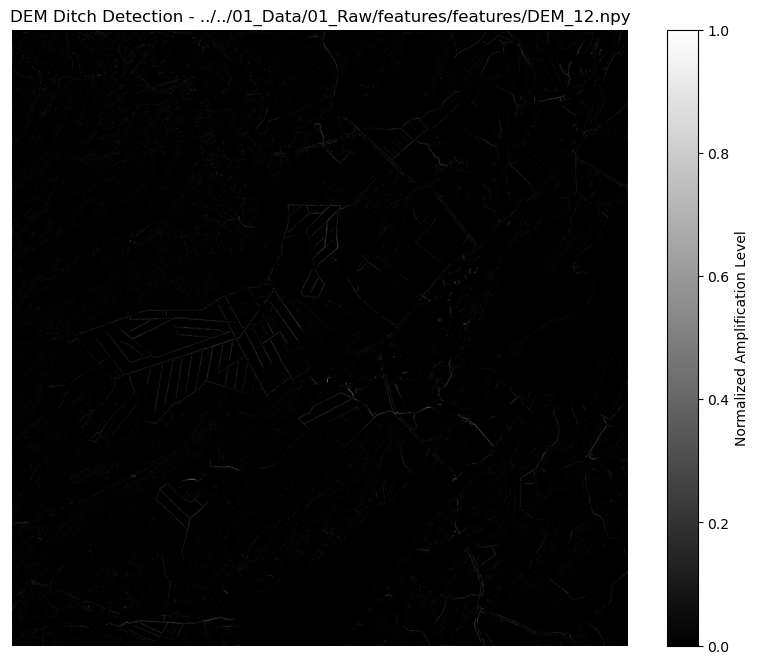

In [4]:
import numpy as np
from scipy.ndimage import generic_filter, binary_closing
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def create_circular_mask(radius):
    """Create a circular boolean mask with given radius"""
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x*x + y*y <= radius*radius
    return mask

def dem_ditch_detection(arr, sensitivity_threshold=-0.08):
    """
    DEM ditch enhancement with adjustable sensitivity threshold.
    """
    arr[arr == -99999] = np.nan  # Replace -99999 with NaN
    newArr = arr.copy()
    maxArr = generic_filter(arr, np.amax, footprint=create_circular_mask(30))
    minArr = generic_filter(arr, np.amin, footprint=create_circular_mask(10))
    meanArr = generic_filter(arr, np.median, footprint=create_circular_mask(10))
    minMaxDiff = arr.copy()

    # Initialize a count variable for detected ditches
    count_ditches = 0

    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if minArr[i][j] < maxArr[i][j] - 3:
                minMaxDiff[i][j] = 1
            else:
                minMaxDiff[i][j] = 0

    closing = binary_closing(minMaxDiff, structure=create_circular_mask(10))
    closing2 = binary_closing(closing, structure=create_circular_mask(10))

    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if arr[i][j] < meanArr[i][j] + sensitivity_threshold:
                newArr[i][j] = meanArr[i][j] - arr[i][j]
                count_ditches += 1  # Increment the count when a ditch is detected
            else:
                newArr[i][j] = 0
            if closing2[i][j] == 1:
                newArr[i][j] = 0

    # Print the count of detected ditches
    print(f"Detected ditches: {count_ditches} pixels")
    return newArr

def visualize_dem_ditch(file_path):
    """Loads the DEM data, processes it, and visualizes it in grayscale."""
    arr = np.load(file_path)
    classified_data = dem_ditch_detection(arr)

    # Normalize the data for visualization
    normalized_data = (classified_data - np.nanmin(classified_data)) / (np.nanmax(classified_data) - np.nanmin(classified_data))

    # Plot the processed data in grayscale
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_data, cmap='gray', origin="lower")
    plt.colorbar(label='Normalized Amplification Level')
    plt.title(f"DEM Ditch Detection - {file_path}")
    plt.axis('off')
    plt.show()

# Example: Load and visualize the DEM image
file_path = "../../01_Data/01_Raw/features/features/DEM_12.npy"
visualize_dem_ditch(file_path)
